# Oregonator Model for B-Z Reaction
The Belousov-Zhabotinsky (BZ) reaction is a well-known chemical oscillator. Although it is a chemical oscillator rather than a biological one, understanding its dynamics can help us understand biological oscillators, such as the heart's rhythmic beating. The system of differential equations describing this reaction is known as the Oregonator model, proposed by Field, Koros, and Noyes in the early 1970s. It shares similarities with models used in biological systems, such as the Beeler-Reuter model for electronegative waves in heart tissue. The primary components involved in the interactions are: 
negatively charged bromine ions $[\text{Br}^-]$, 
positively charged cerium ion ratio $[\text{Ce}^{4+}]/[\text{Ce}^{3+}]$, 
and neutral bromous acid $[\text{HBrO}_2]$. The equations governing the model are :



$$
\begin{aligned}
\epsilon\,\frac{dx}{dt} &= q\,a\,y \;-\; x\,y \;+\; a\,x \;-\; x^2,\\
\gamma\,\frac{dy}{dt} &= -q\,a\,y \;-\; x\,y \;+\; f\,b\,z,\\
\frac{dz}{d\tau} &= a\,x \;-\; b\,z,
\end{aligned}
$$




In this system, the variables $ x $, $ y $, and $ z $ may correspond to $[\text{HBrO}_2]$, $[\text{Br}^-]$, and $[\text{Ce}^{4+}]/[\text{Ce}^{3+}]$, respectively.

### Parameters

- $\epsilon=0.067$
- $\gamma=8.89\times10^{-5}$
- $q=8\times10^{-4}$
- $a=0.2$
- $b=0.25$
- $f=0.65$

In [1]:
import os, sys
print(sys.version)
print("_"* 60)
print(sys.executable)
print("_"* 60)

3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
____________________________________________________________
/home/alka23224/miniconda3/envs/implicit_sindy/bin/python
____________________________________________________________


In [2]:
os.environ["PATH"] = ("/home/alka23224/miniconda3/envs/implicit_sindy/bin:" + os.environ["PATH"])

In [3]:
# -------------------------------
# Current working directory
# -------------------------------
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")


Current working directory: /home/alka23224/Chapter_5_SINDy


In [4]:
# -------------------------------
# Create a Folder for Plots
# -------------------------------
plot_dir = os.path.join(current_dir, "Plots")
os.makedirs(plot_dir, exist_ok=True) 

In [5]:
# -----------------------------
# Import Necessary Libraries
# -----------------------------
import numpy as np
import pandas as pd
import pysindy as ps
import sympy as sp
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import LogFormatter
import plotly.graph_objects as go
from sympy import symbols, Eq, solve, Matrix, N, simplify, nsimplify
from IPython.display import display
from IPython.display import Image
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from pysindy.differentiation import SmoothedFiniteDifference
from pysindy.feature_library import CustomLibrary
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm

In [6]:
import warnings
# Ignore all UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

In [7]:
# Import helper
from plot_utils import set_plot_style, set_spines_black, set_spines_black_3d
from symbolic_parser import build_expr_map, build_symbolic_rhs
from steady_states import find_steady_states
from network_utils import draw_network

In [8]:
# -------------------------------------------
# Define symbolic variable and parameters
# -------------------------------------------
x, y, z = sp.symbols('x y z')
eps = 0.067
gamma = 8.89e-5
q  = 8e-4
a = 0.2
b = 0.25
f = 0.65

dx_dt = (q*a*y - x*y + a*x - x**2)/eps
dy_dt = (-q*a*y - x*y + f*b*z)/gamma
dz_dt =  a*x - b*z
# Display the ODE
print("The system of ODEs:")
print("dx_dt =", dx_dt)
print("dy_dt =", dy_dt)
print("dz_dt =", dz_dt)

The system of ODEs:
dx_dt = -14.9253731343284*x**2 - 14.9253731343284*x*y + 2.98507462686567*x + 0.00238805970149254*y
dy_dt = -11248.5939257593*x*y - 1.79977502812149*y + 1827.89651293588*z
dz_dt = 0.2*x - 0.25*z


In [9]:
# Define Oregonator Model
def oregonator_model(t, state):
    x,y,z = state   # Unpack state variables
    dx_dt = (q*a*y - x*y + a*x - x**2)/eps
    dy_dt = (-q*a*y - x*y + f*b*z)/gamma
    dz_dt =  a*x - b*z
    return [dx_dt, dy_dt,dz_dt]


## Training data 
# Parameters for ODE Integrator 
t0 = 0
tf_train= 100 # Maximum time for the simulation
dt = 0.001  # The time step
t_train= np.arange(t0,tf_train+dt,dt) # Time points for simulation
X0 =[0.1, 0.1, 0.1]  # Initial state of the system

# Solve with solve_ivp
X = solve_ivp(
    oregonator_model,
    t_span=[t0, tf_train],
    y0=X0,
    t_eval=t_train,  
    method='LSODA'    
)
x_train = X.y.T  



## Test Data
tf_test = 50  # Maximum time for the simulation
dt = 0.001  # Time step
t_test = np.arange(0, tf_test, dt)  # Time points for simulation
X0_test = [0.4, 0.2, 0.3]  # Initial state of the system
# Solve with solve_ivp
Xt = solve_ivp(
    oregonator_model,
    t_span=[t0, tf_test],
    y0=X0_test,
    t_eval=t_test,  
    method='LSODA'    
)

x_test = Xt.y.T  

In [10]:
# Print sizes of t_train, x_train, x_test 
print("Size of t_train:", t_train.shape)
print("Size of x_train:", x_train.shape)
print("Size of x_test:", x_test.shape)

Size of t_train: (100001,)
Size of x_train: (100001, 3)
Size of x_test: (50000, 3)


In [11]:
# -----------------------------------
# To fit SINDy model using x_train
# -----------------------------------

In [12]:
model = ps.SINDy()
print(model)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=PolynomialLibrary(), optimizer=STLSQ())


In [13]:
# 1) 
# -----------------------------------
#  Differentiation Method
# -----------------------------------
differentiation_method = SmoothedFiniteDifference()

In [14]:
# 2) Feature Library 
# -----------------------------------
#  Create library : Theta(x)
# -----------------------------------
# [Terms Present in the ODEs]
library = [
    lambda x, y, z: x,
    lambda x, y, z: y,
    lambda x, y, z: z,
    lambda x, y, z: x * y,
    lambda x, y, z: x ** 2]

library_names = [
    lambda x, y, z: "x",
    lambda x, y, z: "y",
    lambda x, y, z: "z",
    lambda x, y, z: "xy",
    lambda x, y, z: "x^2"]
# Create the custom library
custom_library = ps.CustomLibrary(
    library_functions=library,
    function_names=library_names).fit(x_train)

print(custom_library.get_feature_names())

['x', 'y', 'z', 'xy', 'x^2']


In [15]:
# For alpha (regularization strength)
alphas = np.logspace(-15, -1, num=20)  
# For threshold (sparsity cutoff)
thresholds = [0.001, 0.002, 0.01, 0.025] 

# Initialize a matrix to store scores
scores = np.zeros((len(alphas), len(thresholds)))

# Perform Grid Search
for i, alpha in enumerate(tqdm(alphas, desc="Alpha values")):
    # inner tqdm for thresholds; leave=False to not clutter the console
    for j, threshold in enumerate(tqdm(thresholds, desc="Thresholds", leave=False)):
        sindy_optimizer = ps.STLSQ(
            threshold=threshold,
            alpha=alpha,
            max_iter=5000,
            normalize_columns=False
        )
        model = ps.SINDy(
            optimizer=sindy_optimizer,
            feature_library=custom_library,
            feature_names=["x","y","z"]
        )
        model.fit(x_train, t=dt)
        scores[i, j] = model.score(x_test, t=dt)

print('Grid search complete!')

Alpha values:   0%|          | 0/20 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/4 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/4 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/4 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/4 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/4 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/4 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/4 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/4 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/4 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/4 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/4 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/4 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/4 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/4 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/4 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/4 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/4 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/4 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/4 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/4 [00:00<?, ?it/s]

Grid search complete!


In [16]:
# Find the best hyperparameters
best_score = np.max(scores)
best_idx = np.unravel_index(np.argmax(scores), scores.shape)
best_alpha = alphas[best_idx[0]]
best_threshold = thresholds[best_idx[1]]

# Print the best hyperparameters and score
print(f"Optimal alpha: {best_alpha:.1e}")
print(f"Optimal threshold: {best_threshold:.1e}")
print(f"Optimal score: {best_score:.6f}")

Optimal alpha: 1.1e-04
Optimal threshold: 2.0e-03
Optimal score: 0.999290


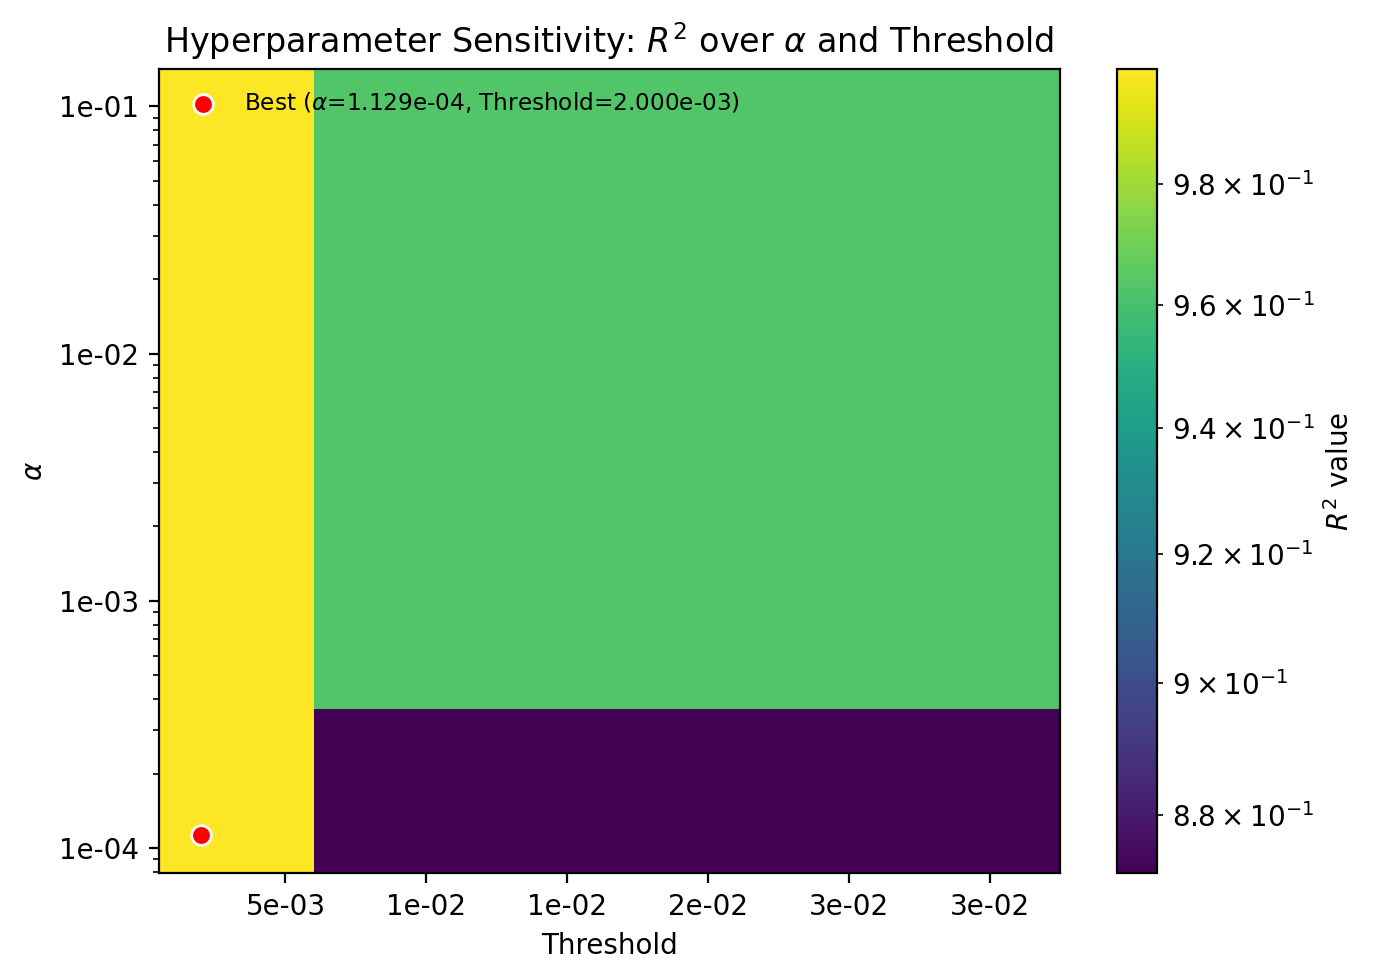

In [37]:
#####################################################
# Plot the Heatmap of R square Scores
plt.figure(figsize=(7, 5), dpi=200)

# Draw the heatmap 
X, Y = np.meshgrid(thresholds, alphas)
mesh = plt.pcolormesh(
    X, Y, scores,
    norm=colors.LogNorm(vmin=scores.min(), vmax=scores.max()),
    cmap='viridis',
    shading='auto'
)

cbar = plt.colorbar(mesh, label="$R^2$ value", format=LogFormatter())
cbar.ax.yaxis.set_tick_params(labelsize='small')
ax = plt.gca()
# ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))

# Mark the optimal
plt.scatter(
    best_threshold, best_alpha,
    color='red', s=50, edgecolor='white',
    label=f'Best ($\\alpha$={best_alpha:.3e}, Threshold={best_threshold:.3e})'
)

# 5) Labels, title, legend
plt.xlabel("Threshold", fontsize='medium')
plt.ylabel("$\\alpha$", fontsize='medium')
plt.title("Hyperparameter Sensitivity: $R^2$ over $\\alpha$ and Threshold", fontsize='large')

plt.legend(
    loc='upper left',
    frameon=False,
    fontsize='small'
)

# 7) Save as vector graphic
plt.tight_layout()
# plt.savefig("heatmap_r2.pdf", bbox_inches="tight")
plt.show()


In [18]:
## Define the Optimizer
sindy_optimizer = ps.STLSQ(
    threshold= best_threshold,
    alpha = best_alpha,
    max_iter=5000,
    normalize_columns=False
)
## Initialize the SINDy model
model = ps.SINDy(
    optimizer=sindy_optimizer,
    feature_library=custom_library,
    feature_names=["x", "y", "z"]
)
## Fit the SINDy model
model.fit(x_train, t=dt)

# Print the Learned Equations
print("The equations learned using SINDy:")
model.print(lhs=["dx/dt", "dy/dt", "dz/dt"])

The equations learned using SINDy:
dx/dt = 2.983 x + 0.002 y + -14.928 xy + -14.909 x^2
dy/dt = -0.031 x + -1.800 y + 1827.942 z + -11249.478 xy + 0.369 x^2
dz/dt = 0.200 x + -0.250 z


In [19]:
# The system of ODEs:
# dx_dt = -14.9253731343284*x**2 - 14.9253731343284*x*y + 2.98507462686567*x + 0.00238805970149254*y
# dy_dt = -11248.5939257593*x*y - 1.79977502812149*y + 1827.89651293588*z
# dz_dt = 0.2*x - 0.25*z


In [20]:
print('The total number of terms present in the model:', model.complexity)

The total number of terms present in the model: 12


In [21]:
candidate_name = custom_library.get_feature_names()
sindy_coefficients = np.round(model.coefficients(),3)
sindy_results =pd.DataFrame(sindy_coefficients,
                                 index=["dx/dt", "dy/dt", "dz/dt"],
                                 columns=candidate_name)
# Display the DataFrame
print("SINDy Results:")
print(sindy_results)

SINDy Results:
           x      y         z         xy     x^2
dx/dt  2.983  0.002    -0.000    -14.928 -14.909
dy/dt -0.031 -1.800  1827.942 -11249.478   0.369
dz/dt  0.200  0.000    -0.250      0.000   0.000


In [22]:
# Simulate using the learned model
x_train_simulated = model.simulate(x_train[0], t_train)

In [23]:
forward_time = np.arange(0, tf_train + 100, dt)
x_train_simulated_forward = model.simulate(x_train[0], forward_time)

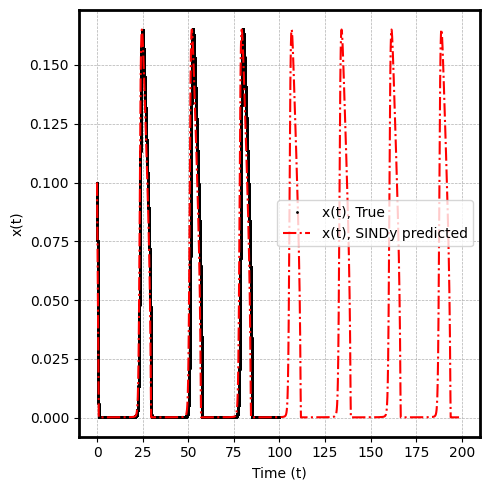

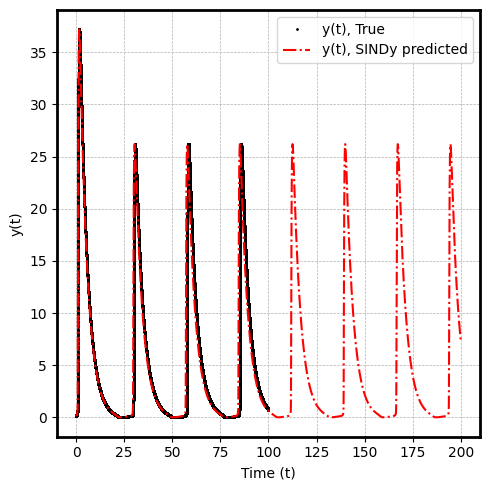

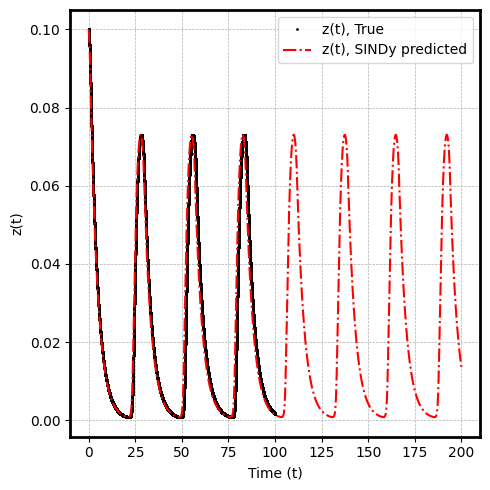

In [24]:
## Plot the results
# Plot x(t) 
fig1, ax1 = plt.subplots(figsize=(5, 5), dpi=100)
ax1.plot(t_train, x_train[:, 0], 'k.', label='x(t), True', markersize=2)
ax1.plot(forward_time, x_train_simulated_forward[:, 0], 'r-.',
         label='x(t), SINDy predicted', linewidth=1.5)
ax1.set(xlabel='Time (t)', ylabel='x(t)')
ax1.grid(True, which='both', ls='--', lw=0.5)
ax1.legend()
set_spines_black(ax1)
fig1.tight_layout()
plt.show()

# Plot y(t) 
fig2, ax2 = plt.subplots(figsize=(5, 5), dpi=100)
ax2.plot(t_train, x_train[:, 1], 'k.', label='y(t), True', markersize=2)
ax2.plot(forward_time, x_train_simulated_forward[:, 1], 'r-.',
         label='y(t), SINDy predicted', linewidth=1.5)
ax2.set(xlabel='Time (t)', ylabel='y(t)')
ax2.grid(True, which='both', ls='--', lw=0.5)
ax2.legend()
set_spines_black(ax2)
fig2.tight_layout()
plt.show()


# Plot z(t) 
fig3, ax3 = plt.subplots(figsize=(5, 5), dpi=100)
ax3.plot(t_train, x_train[:, 2], 'k.',          
         label='z(t), True', markersize=2)
ax3.plot(forward_time, x_train_simulated_forward[:, 2], 'r-.',
         label='z(t), SINDy predicted', linewidth=1.5)
ax3.set(xlabel='Time (t)', ylabel='z(t)')
ax3.grid(True, which='both', ls='--', lw=0.5)
ax3.legend()
set_spines_black(ax3)
fig3.tight_layout()
plt.show()

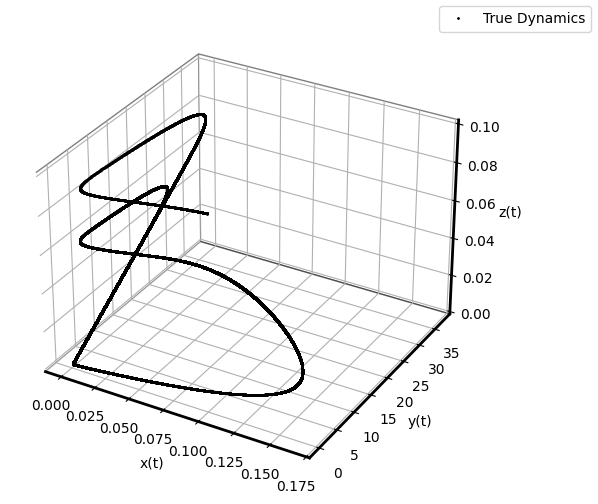

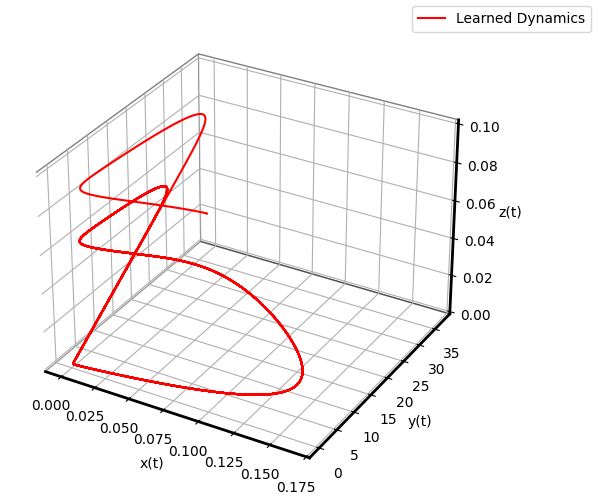

In [25]:
# Phase Digram
# 1) True Dynamics
fig1 = plt.figure(figsize=(7, 5), dpi=100)
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(
    x_train[:, 0], x_train[:, 1], x_train[:, 2],
    'k.', markersize=2, label='True Dynamics'
)
ax1.set(xlabel='x(t)', ylabel='y(t)', zlabel='z(t)')
ax1.grid(True, which='both', ls='--', lw=0.5)
fig1.legend()
set_spines_black_3d(ax1)
fig1.tight_layout()
plt.show()

# 2) Learned Dynamics
fig2 = plt.figure(figsize=(7, 5), dpi=100)
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot(
    x_train_simulated_forward[:, 0],
    x_train_simulated_forward[:, 1],
    x_train_simulated_forward[:, 2],
    'r-', linewidth=1.5, label='Learned Dynamics')
ax2.set(xlabel='x(t)', ylabel='y(t)', zlabel='z(t)')
fig2.legend()
ax2.grid(True, which='both', ls='--', lw=0.5)
set_spines_black_3d(ax2)
fig2.tight_layout()
plt.show()


# **Interaction Network using Jacobian**

In [26]:
feature_names = model.get_feature_names()
coeffs = model.coefficients()

# Create symbolic expressions
dx_dt = build_symbolic_rhs(coeffs[0], feature_names)
dy_dt = build_symbolic_rhs(coeffs[1], feature_names)
dz_dt = build_symbolic_rhs(coeffs[2], feature_names)


In [27]:
from sympy import lambdify
f_numeric = lambdify((x, y, z),
                     (dx_dt, dy_dt, dz_dt),
                     modules='numpy')

# Steady states Function
def system_func(vars):
    xv, yv, zv = vars
    return f_numeric(xv, yv, zv)

# Find steady states
steady_states = find_steady_states(system_func,
                                   num_vars=3,
                                   num_samples=5000,
                                   tol=1e-8,
                                   domain=[(0,2),(0,10),(0,100)])

print("Steady states for the given system are:")
for i, (x_ss, y_ss, z_ss) in enumerate(steady_states, start=1):
    x_val = sp.N(x_ss, 3)
    y_val = sp.N(y_ss, 3)
    z_val = sp.N(z_ss, 3)
    print(f"  Steady state {i}:(x,y,z)=({x_val},{y_val},{z_val})")


Steady states for the given system are:
  Steady state 1:(x,y,z)=(0.0705,0.130,0.0564)
  Steady state 2:(x,y,z)=(0,0,0)


In [28]:
# Define the Jacobian matrix
vars = sp.Matrix([x, y, z])
f = sp.Matrix([dx_dt, dy_dt, dz_dt])
J = f.jacobian(vars).applyfunc(lambda expr: expr.evalf(3))

print("\nJacobian matrix:")
display(J)


Jacobian matrix:


Matrix([
[     -29.8*x - 14.9*y + 2.98, 0.00239 - 14.9*x, -0.000311],
[0.739*x - 1.13e+4*y - 0.0308, -1.13e+4*x - 1.8,   1.83e+3],
[                         0.2,                0,     -0.25]])

In [29]:
# Evaluate the Jacobian at steady state 1
J_evaluated_1 = J.subs({x:steady_states[0][0],y:steady_states[0][1],z:steady_states[0][2]}).evalf(3)
display(J_evaluated_1)

Matrix([
[   -1.06,  -1.05, -0.000311],
[-1.46e+3, -795.0,   1.83e+3],
[     0.2,      0,     -0.25]])

In [30]:
eigs_1 = J_evaluated_1.eigenvals() 
print("Eigenvalues at steady state 1:")
for ev, mult in eigs_1.items():
    print(f"  {N(ev,3)}  (multiplicity {mult})")

Eigenvalues at steady state 1:
  -797.0 + 8.71e-17*I  (multiplicity 1)
  0.31 - 0.41*I  (multiplicity 1)
  0.31 + 0.41*I  (multiplicity 1)



The Interaction Network corresponding to this Jacobian Matrix is:


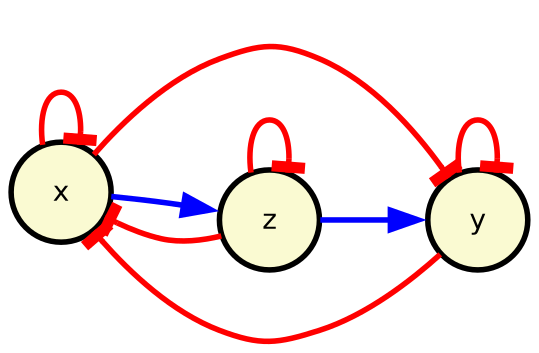

In [31]:
# Define the Jacobian matrix
nodes = ["x", "y", "z"]
jacobian_matrix_1 = np.array(J_evaluated_1.tolist(), dtype=float)
# Draw the network
graph_1 = draw_network(jacobian_matrix_1,
                     nodes,
                     output_path='Oregonator_SINDy1',
                     label_fontsize=10,
                     graph_size='10,10',
                    dpi =200)
# Display the generated PNG
print(f"\nThe Interaction Network corresponding to this Jacobian Matrix is:")
Image(filename='Oregonator_SINDy1.png')

In [32]:
# Evaluate the Jacobian at steady state 2
J_evaluated_2 = J.subs({x:steady_states[1][0],y:steady_states[1][1],z:steady_states[1][2]}).evalf(3)
display(J_evaluated_2)

Matrix([
[   2.98, 0.00239, -0.000311],
[-0.0308,    -1.8,   1.83e+3],
[    0.2,       0,     -0.25]])

In [33]:
eigs_2 = J_evaluated_2.eigenvals() 
print("Eigenvalues at steady state 2:")
for ev, mult in eigs_2.items():
    print(f"  {N(ev,3)}  (multiplicity {mult})")

Eigenvalues at steady state 2:
  3.04  (multiplicity 1)
  -1.67  (multiplicity 1)
  -0.437  (multiplicity 1)



The Interaction Network corresponding to this Jacobian Matrix is:


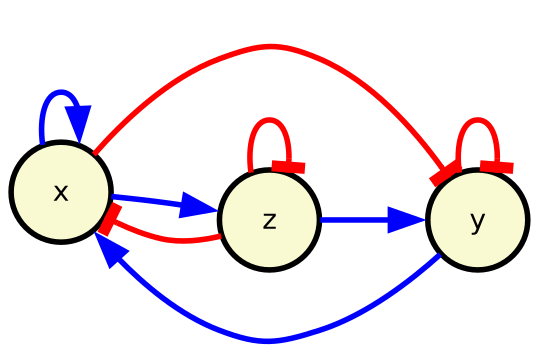

In [34]:
jacobian_matrix_2 = np.array(J_evaluated_2.tolist(), dtype=float)
# Draw the network
graph_2 = draw_network(jacobian_matrix_2,
                     nodes,
                     output_path='Oregonator_SINDy2',
                     label_fontsize=10,
                     graph_size='10,10',
                    dpi =200)
# Display the generated PNG
print(f"\nThe Interaction Network corresponding to this Jacobian Matrix is:")
Image(filename='Oregonator_SINDy2.png')

In [35]:
#---------------------------------------------------------END------------------------------------------------------------------